In [9]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg       
import matplotlib.pyplot as plt        
import matplotlib.patches as mpatches 
from skimage import measure         
import scipy.ndimage as ndi  
from os.path import exists, join
from os import listdir
import sys

In [10]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (6, 6) 

In [11]:
import os
images = os.listdir('sample_data/images')
images

['10.jpg',
 '2.jpg',
 '7.jpg',
 '6.jpg',
 '5.jpg',
 '9.jpg',
 '3.jpg',
 '695.jpg',
 '8.jpg']

In [12]:
import os
from skimage import io

In [16]:
def input_img (img_file):
    img_dir = 'sample_data/images'
#     user_input = input('Enter file name')
    if os.path.exists(img_file):
        img = io.imread(img_file)
        return img
    else:
        return f'file not found'

Enter file name : 2.jpg


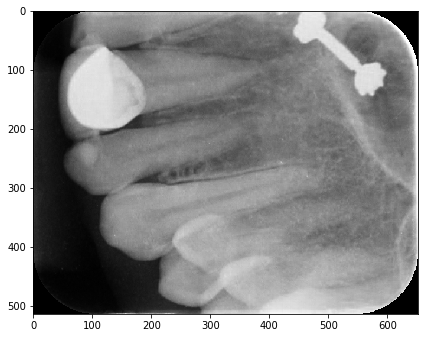

In [19]:
img_dir = 'sample_data/images'
user_input = input('Enter file name : ')

img_file_path = os.path.join(img_dir, user_input)
img = input_img(img_file_path)
io.imshow(img)

In [26]:
img = img_dir
print(type(img))
lum_img = img[:, :, 0]
plt.imshow(lum_img)

<class 'str'>


TypeError: string indices must be integers

ValueError: not enough values to unpack (expected 2, got 1)